# 1) Постановка задачи

### Идентификация пользователей по посещенным веб-страницам

В этом проекте решалась задача идентификации пользователя по его поведению в сети Интернет: по последовательности из нескольких веб-сайтов, посещенных подряд одним и тем же человеком. 

**Идея**: каждый ползователь имеет личные особенности и интересы, что отражается на его активности в Интернете. В зависимости от образа жизни, места работы, семейного положения и других факторов ползователь посещает некоторые сайты, в некоторое время, с некоторой частотой. Заметив аномальную сессию, не характерную для данного пользователя, можно с некоторой вероятностью прогнозировать факт взлома пользователя. Определив допустимый порог данной вероятности для неординарной сессии можно обезопасить пользователя от несанкционированной авторизации, тем самым сохраняя и преумножая лояльность клиентов сервиса. 

**Данные**:
Представленные данные взяты из статьи "A Tool for Classification of Sequential Data".

Имеются данные с прокси-серверов Университета Блеза Паскаля. Для каждого пользователя заведен csv-файл с названием user****.csv (где вместо звездочек – 4 цифры, соответствующие ID пользователя), а в нем посещения сайтов записаны в следующем формате:


| timestamp               | site            | 
|:-------------           |:---------------:| 
| 2013-11-15 08:12:07     | google.com      |
| 2013-11-15 08:12:38     | youtube.com     |
| 2013-11-15 08:12:58     | github.com      |



Подробности, источники данных и другая информация содержится в соревновании:

https://www.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2

# 2) Извлечение признаков

In [33]:
from __future__ import division, print_function
# отключим предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
import os
import pickle
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, roc_curve

from matplotlib import pyplot as plt
import seaborn as sns

from datetime import datetime
start_time = datetime(1970, 1, 1)
import csv
import time

**Путь к файлам**

In [2]:
t0 = time.clock()

In [3]:
PATH_TO_DATA = r'C:\Users\Anatoly\1python\1coursera\MachineLearning\6courseFinalProjects\UserIdentification\5. Соревнование\KaggleData'

**Чтение файлов csv**

In [4]:
# datasets load from kaggle
train_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_sessions.csv'),
                       index_col='session_id')
test_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'test_sessions.csv'),
                      index_col='session_id')

# target on test data is unknown
test_df['target'] = None

**Объединение трейн и тест**

In [5]:
train_test_df = pd.concat([train_df, test_df])
train_test_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
1,718,2014-02-20 10:02:45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,890,2014-02-22 11:19:50,941.0,2014-02-22 11:19:50,3847.0,2014-02-22 11:19:51,941.0,2014-02-22 11:19:51,942.0,2014-02-22 11:19:51,...,2014-02-22 11:19:51,3847.0,2014-02-22 11:19:52,3846.0,2014-02-22 11:19:52,1516.0,2014-02-22 11:20:15,1518.0,2014-02-22 11:20:16,0
3,14769,2013-12-16 16:40:17,39.0,2013-12-16 16:40:18,14768.0,2013-12-16 16:40:19,14769.0,2013-12-16 16:40:19,37.0,2013-12-16 16:40:19,...,2013-12-16 16:40:19,14768.0,2013-12-16 16:40:20,14768.0,2013-12-16 16:40:21,14768.0,2013-12-16 16:40:22,14768.0,2013-12-16 16:40:24,0
4,782,2014-03-28 10:52:12,782.0,2014-03-28 10:52:42,782.0,2014-03-28 10:53:12,782.0,2014-03-28 10:53:42,782.0,2014-03-28 10:54:12,...,2014-03-28 10:54:42,782.0,2014-03-28 10:55:12,782.0,2014-03-28 10:55:42,782.0,2014-03-28 10:56:12,782.0,2014-03-28 10:56:42,0
5,22,2014-02-28 10:53:05,177.0,2014-02-28 10:55:22,175.0,2014-02-28 10:55:22,178.0,2014-02-28 10:55:23,177.0,2014-02-28 10:55:23,...,2014-02-28 10:55:59,175.0,2014-02-28 10:55:59,177.0,2014-02-28 10:55:59,177.0,2014-02-28 10:57:06,178.0,2014-02-28 10:57:11,0


В обучающей выборке видим следующие признаки:
    - site1 – индекс первого посещенного сайта в сессии
    - time1 – время посещения первого сайта в сессии
    - ...
    - site10 – индекс 10-го посещенного сайта в сессии
    - time10 – время посещения 10-го сайта в сессии
    - target 
    
Сессии пользователей выделены таким образом, что они не могут быть длинее получаса или 10 сайтов. То есть сессия считается оконченной либо когда пользователь посетил 10 сайтов подряд, либо когда сессия заняла по времени более 30 минут. 

Таргет представлен в виде:
- **1** - Алиса
- **0** - не Алиса 

**В обучающей выборке – 2297 сессий одного пользователя (Alice) и 251264 сессий – других пользователей, не Элис. Дисбаланс классов очень сильный, и смотреть на долю верных ответов (accuracy) непоказательно.**

In [6]:
train_df['target'].value_counts()

0    251264
1      2297
Name: target, dtype: int64

## 2.1 Признаки по времени посещения сайтов

Для каждой группы найдем следующие признаки:
- День недели посещения
- Час начала сессии
- Время перехода на следующий сайт
- Продолжительность сессии

**Пока для прогноза будем использовать только индексы посещенных сайтов. Индексы нумеровались с 1, так что заменим пропуски на нули.**

In [7]:
train_test_df_date = train_test_df[['time%d' % i for i in range(1, 11)]].fillna(0)

В дата сете время посещения - strings, нужно преобразовывать в формат времени.

In [8]:
def trans_date(date):
    '''Transform str to datetime
    date: str
        format Year-month-day Hour:Min:Sec
    '''
    return datetime.strptime(date, '%Y-%m-%d %H:%M:%S')


### Собираем признаки для всех сессий

**Время перехода на следующий сайт**

In [9]:
%%time
# time for watching one site
for i in range (1,train_test_df_date.shape[1]):
    
    first_site_vect = train_test_df_date['time'+str(i)]
    second_site_vect = train_test_df_date['time'+str(i+1)]
    delay_vect = []
    for time1, time2 in zip(first_site_vect, second_site_vect):
        if time2==0:
            delay_vect.append(-1)
        else:
            delay = trans_date(time2) - trans_date(time1)
            delay_vect.append(delay.seconds)
    
    train_test_df_date['delay'+str(i)] = delay_vect



Wall time: 52.3 s


In [10]:
%%time
loc_df = train_test_df_date[['delay'+str(i) for i in range(1,10)]].copy()
mean_delay = []
timespan = []
for i in range(len(loc_df)):
    positive = loc_df.iloc[i][loc_df.iloc[i]>=0]
    len_positive = len(positive)
    
    cur_timespan = sum(positive)
    timespan.append(cur_timespan)
    if len_positive == 0:
        mean_delay.append(0)
    else:
        mean_delay.append(cur_timespan/len_positive)

train_test_df_date['mean_delay'] = mean_delay
train_test_df_date['timespan'] = timespan

del loc_df

Wall time: 2min 51s


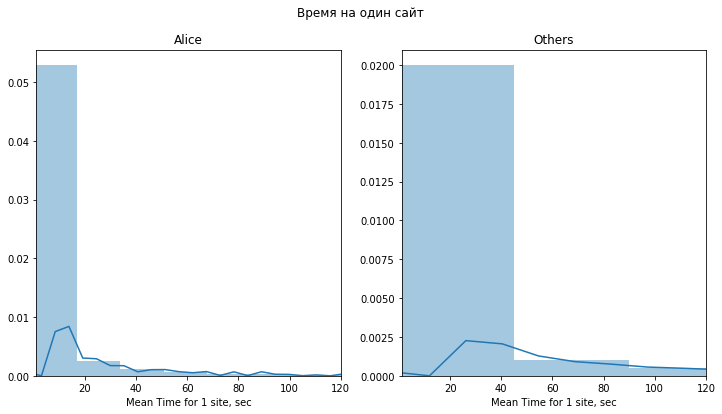

In [11]:
plt.subplots(1, 2, figsize = (12, 6)) 
plt.suptitle('Время на один сайт')

plt.subplot(1, 2, 1)
sns.distplot(train_test_df_date['mean_delay'][train_df['target'] == 1], bins=40)
plt.title("Alice")
plt.xlim(1,120)
plt.xlabel('Mean Time for 1 site, sec')
          
plt.subplot(1, 2, 2)
sns.distplot(train_test_df_date['mean_delay'][train_df['target'] == 0], bins=40)
plt.title('Others')
plt.xlim(1,120)
plt.xlabel('Mean Time for 1 site, sec');

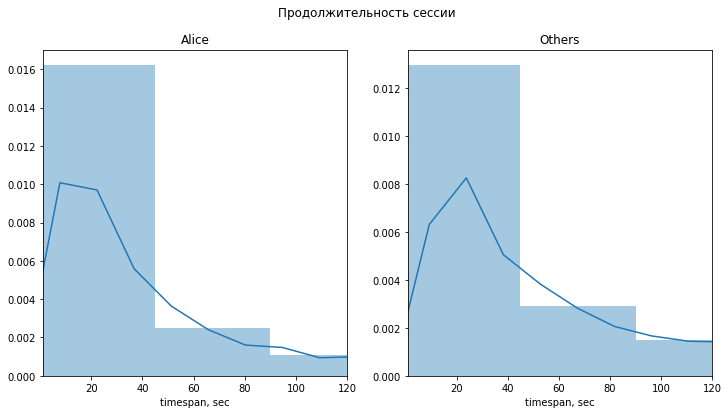

In [12]:
plt.subplots(1, 2, figsize = (12, 6)) 
plt.suptitle('Продолжительность сессии')

plt.subplot(1, 2, 1)
sns.distplot(train_test_df_date['timespan'][train_df['target'] == 1], bins=40)
plt.title("Alice")
plt.xlim(1,120)
plt.xlabel('timespan, sec')
          
plt.subplot(1, 2, 2)
sns.distplot(train_test_df_date['timespan'][train_df['target'] == 0], bins=40)
plt.title('Others')
plt.xlim(1,120)
plt.xlabel('timespan, sec');

**Час сессии**

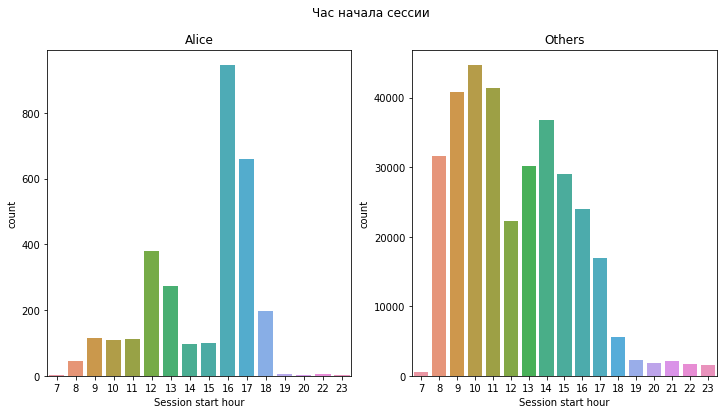

In [13]:
# hour of session start 
train_test_df_date['hour'] = [trans_date(date).hour for date in train_test_df_date['time1']]

plt.subplots(1, 2, figsize = (12, 6)) 
plt.suptitle('Час начала сессии')

plt.subplot(1, 2, 1)
sns.countplot(train_test_df_date['hour'][train_df['target'] == 1])
plt.title("Alice")
plt.xlabel('Session start hour')
          
plt.subplot(1, 2, 2)
sns.countplot(train_test_df_date['hour'][train_df['target'] == 0])
plt.title('Others')
plt.xlabel('Session start hour');

**День недели сессии**

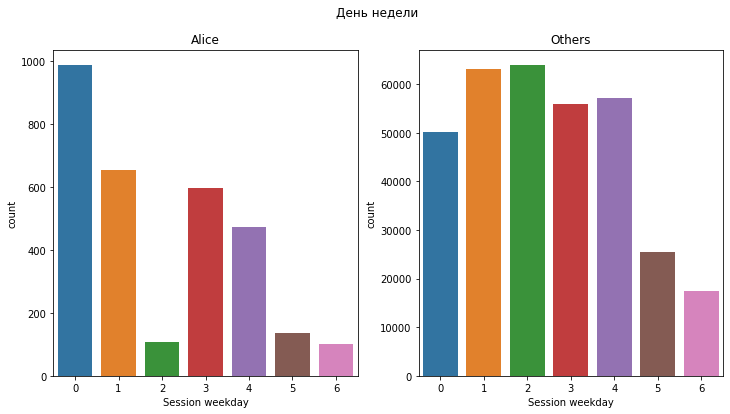

In [14]:
# weekday of session
train_test_df_date['week_day'] = [trans_date(date).weekday() for date in train_test_df_date.time1]

plt.subplots(1, 2, figsize = (12, 6)) 
plt.suptitle('День недели')
plt.subplot(1, 2, 1)
sns.countplot(train_test_df_date['week_day'][train_df['target'] == 1])
plt.title("Alice")
plt.xlabel('Session weekday')
          
plt.subplot(1, 2, 2)
sns.countplot(train_test_df_date['week_day'][train_df['target'] == 0])
plt.title('Others')
plt.xlabel('Session weekday');

## 2.2 Признаки по сайтам

Вычислим для каждой группы ключевые признаки посещения сайтов:
- Число топ сайтов в сессии
- Число уникальных 
- Число уникальных топ сайтов

In [15]:
train_test_df_sites = train_test_df[['site%d' % i for i in range(1, 11)]].fillna(0).astype('int')

**Создание словаря частот** (на Kaggle есть готовый, но нужно уметь делать самому)

In [16]:
%%time
site_dict = dict()
for i in range(train_test_df_sites.shape[0]):
    for j in range(train_test_df_sites.shape[1]):
        site = train_test_df_sites.iloc[i,j]
        if site not in site_dict.keys():
            site_dict[site] = 1
        else:
            site_dict[site] += 1
# sorting            
site_dict = {k: v for k, v in sorted(site_dict.items(), key=lambda item: item[1], reverse = True)}

Wall time: 5min 58s


Список топ сайтов (id=0 удаляем): 

In [17]:
top_sites = [key for key in site_dict.keys() if site_dict[key]>20000]
# del 0 - it is Nan
top_sites.remove(0)

**Посещение топ сайтов**

In [18]:
%%time
length_shape = len(train_test_df_sites)
width_shape = train_test_df_sites.shape[1]

# Number of top sites in session for each row
n_top = [sum([train_test_df_sites.iloc[i,k] in top_sites for k in range(width_shape)]) for i in range(length_shape)]
train_test_df_date['n_top'] = n_top

Wall time: 5min 56s


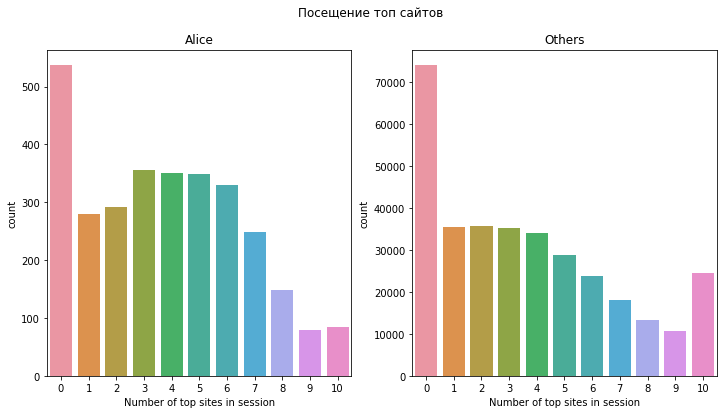

In [19]:
plt.subplots(1, 2, figsize = (12, 6)) 
plt.suptitle('Посещение топ сайтов')

plt.subplot(1, 2, 1)
sns.countplot(train_test_df_date['n_top'][train_df['target'] == 1])
plt.title("Alice")
plt.xlabel('Number of top sites in session')
          
plt.subplot(1, 2, 2)
sns.countplot(train_test_df_date['n_top'][train_df['target'] == 0])
plt.title('Others')
plt.xlabel('Number of top sites in session');

**Уникальных сайтов в сессии**

In [20]:
%%time

length_shape = len(train_test_df_sites)
width_shape = train_test_df_sites.shape[1]

loc_df = train_test_df_sites.copy()
# Len of list with unique sites exclude 0 for each row
n_unique = [len(loc_df.iloc[i].unique()[loc_df.iloc[i].unique()!=0]) for i in range(length_shape)]
del loc_df

train_test_df_date['n_unique'] = n_unique

Wall time: 1min 52s


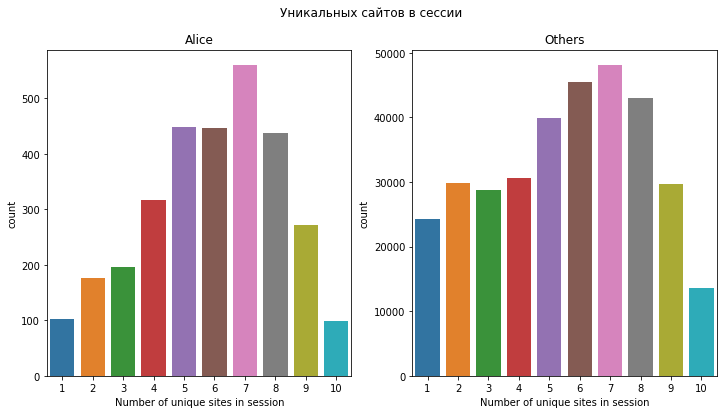

In [21]:
plt.subplots(1, 2, figsize = (12, 6)) 
plt.suptitle('Уникальных сайтов в сессии')
plt.subplot(1, 2, 1)
sns.countplot(train_test_df_date['n_unique'][train_df['target'] == 1])
plt.title("Alice")
plt.xlabel('Number of unique sites in session')
          
plt.subplot(1, 2, 2)
sns.countplot(train_test_df_date['n_unique'][train_df['target'] == 0])
plt.title('Others')
plt.xlabel('Number of unique sites in session');

**Уникальных топ сайтов в сессии**

In [22]:
%%time

length_shape = len(train_test_df_sites)
width_shape = train_test_df_sites.shape[1]

loc_df = train_test_df_sites.copy()
# Len of list with unique sites exclude 0 for each row
n_top_unique = [len(set(loc_df.iloc[i]) & set(top_sites)) for i in range(length_shape)]
del loc_df

train_test_df_date['n_top_unique'] = n_top_unique

Wall time: 31.1 s


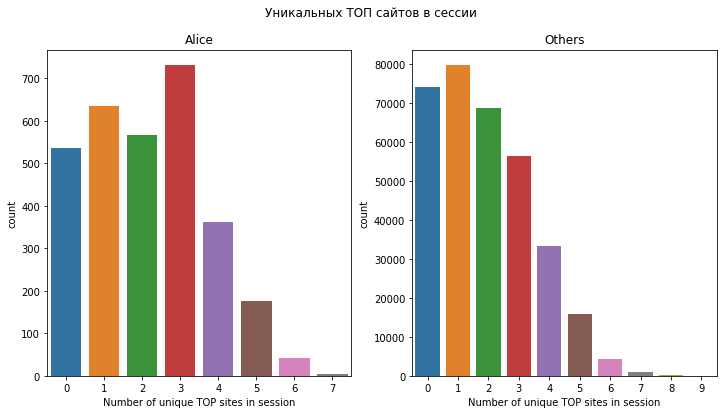

In [23]:
plt.subplots(1, 2, figsize = (12, 6)) 
plt.suptitle('Уникальных ТОП сайтов в сессии')
plt.subplot(1, 2, 1)
sns.countplot(train_test_df_date['n_top_unique'][train_df['target'] == 1])
plt.title("Alice")
plt.xlabel('Number of unique TOP sites in session')
          
plt.subplot(1, 2, 2)
sns.countplot(train_test_df_date['n_top_unique'][train_df['target'] == 0])
plt.title('Others')
plt.xlabel('Number of unique TOP sites in session');

Визуальный анализ.

По полуенным распределениям признаков видно, что профиль Алисы отличается от основной массы пользователей.

- Алиса часто заходит в интернет по понедельникам и редко по средам.
- Пик активности приходится 16-17 часов
- Алиса часто посещает три разных сайта из топ списка

## 2.3 Признаки последовательности сайтов сессии


In [24]:
train_test_df_sites

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10
session_id,,,,,,,,,,
1,718,0,0,0,0,0,0,0,0,0
2,890,941,3847,941,942,3846,3847,3846,1516,1518
3,14769,39,14768,14769,37,39,14768,14768,14768,14768
4,782,782,782,782,782,782,782,782,782,782
5,22,177,175,178,177,178,175,177,177,178
...,...,...,...,...,...,...,...,...,...,...
82793,812,1039,676,0,0,0,0,0,0,0
82794,300,302,302,300,300,1222,302,1218,1221,1216
82795,29,33,35,22,37,6779,30,21,23,6780


Плотную матрицу необходимо преобразовать в формат sparse_matrix разреженного вида.

In [25]:
def matrix_to_csr(inp_matrix):    
    docs = inp_matrix
    indptr = [0]
    indices = []
    data = []
    vocabulary = {}
    for d in docs:
        for term in d:
            if term:
                index = term
                indices.append(index)
                data.append(1)
        indptr.append(len(indices))
    
    sparse_matrix=csr_matrix((data, indices, indptr), dtype=int)[:,1:] # удаляем нулевой столбец
    return sparse_matrix

In [26]:
train_test_sparse = matrix_to_csr(train_test_df_sites.values)
X_train_sparse = train_test_sparse[:train_df.shape[0]]
X_test_sparse = train_test_sparse[train_df.shape[0]:]
y = train_df.target

# 3) Построение классификатора

**Разобьем обучающую выборку на 2 части в пропорции 7/3, причем не перемешивая. Исходные данные упорядочены по времени, тестовая выборка по времени четко отделена от обучающей, это же соблюдем и здесь.**

In [27]:
train_share = int(.7 * X_train_sparse.shape[0])
X_train, y_train = X_train_sparse[:train_share, :], y[:train_share]
X_valid, y_valid  = X_train_sparse[train_share:, :], y[train_share:]

train_index = y[:train_share].index
valid_index = y[train_share:].index

Функция для построения валидационных кривых

In [28]:
def plot_validation_curves(param_values, grid_cv_results_):
    train_mu, train_std = grid_cv_results_['mean_train_score'], grid_cv_results_['std_train_score']
    valid_mu, valid_std = grid_cv_results_['mean_test_score'], grid_cv_results_['std_test_score']
    
    plt.figure(figsize=(9,6))
    train_line = plt.plot(param_values, train_mu, '-', label='train', color='green')
    valid_line = plt.plot(param_values, valid_mu, '-', label='test', color='red')
    
    plt.fill_between(param_values, train_mu - train_std, train_mu + train_std, edgecolor='none',
                     facecolor=train_line[0].get_color(), alpha=0.2)
    plt.fill_between(param_values, valid_mu - valid_std, valid_mu + valid_std, edgecolor='none',
                     facecolor=valid_line[0].get_color(), alpha=0.2)
    
    plt.title('Validation Curves')
    plt.xlabel('alpha')
    plt.ylabel('ROC AUC score')
    plt.legend()
    plt.show()

Грубый поиск

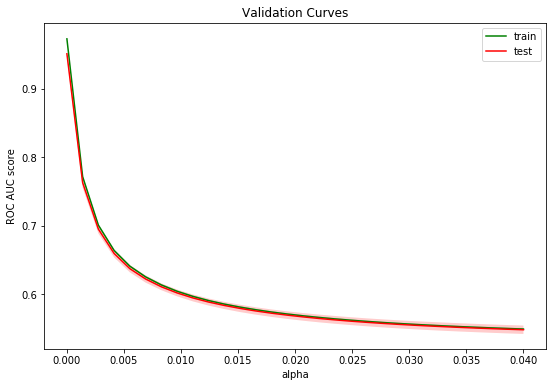

In [29]:
param_grid_sgd = {'alpha': np.linspace(1e-5, 0.04, 30)}
sgd_logit = SGDClassifier(loss='log', random_state=17, n_jobs=-1)

grid_search = GridSearchCV(sgd_logit, param_grid=param_grid_sgd,
                           scoring='roc_auc',
                           n_jobs=-1, cv=5, return_train_score=True)
grid_search.fit(X_train, y_train)

plot_validation_curves(param_grid_sgd['alpha'], grid_search.cv_results_)

Точный поиск

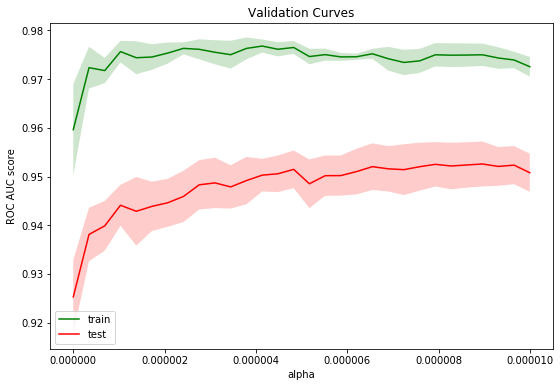

In [30]:
param_grid_sgd2 = {'alpha': np.linspace(1e-9, 1e-5, 30)}
sgd_logit = SGDClassifier(loss='log', random_state=17, n_jobs=-1)

grid_search2 = GridSearchCV(sgd_logit, param_grid=param_grid_sgd2,
                           scoring='roc_auc',
                           n_jobs=-1, cv=5, return_train_score=True)
grid_search2.fit(X_train, y_train)

plot_validation_curves(param_grid_sgd2['alpha'], grid_search2.cv_results_)

### ROC и PR кривые

In [31]:
best_log_sgd = grid_search2.best_estimator_

In [34]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
y_score = best_log_sgd.predict_proba(X_valid)[:,1]
fpr, tpr, thresholds = roc_curve(y_valid, y_score)
roc_auc = auc(fpr, tpr)

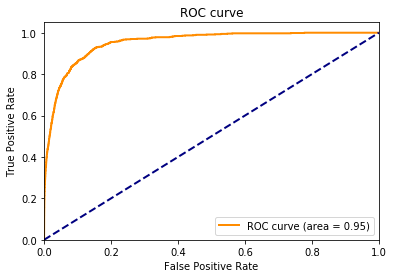

In [35]:
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc)

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

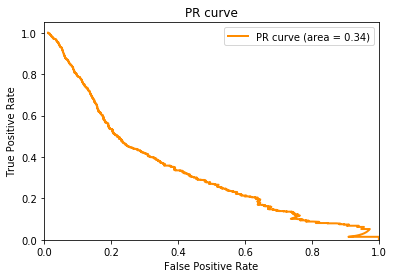

In [36]:
pr, rec, _ = precision_recall_curve(y_valid, y_score)

plt.plot(pr, rec, color='darkorange',
         lw=2, label='PR curve (area = %0.2f)' % auc(rec, pr))

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('PR curve')
plt.legend(loc="upper right")
plt.show()

Посмотрим на какой доле объектов наша модель дает результат лучше константного.

In [37]:
p_alice = len(y[y==1])/len(y)

print(f'Априорная вероятность принадлежности к классу Алиса = {p_alice}')

Априорная вероятность принадлежности к классу Алиса = 0.00905896411514389


In [38]:
true_share = len(y_score[(y_score > p_alice) & (y_valid==1)])/(len(y_valid[y_valid==1]))
print(f'Доля объектов где модель лучше константы = {true_share}')

Доля объектов где модель лучше константы = 0.880057803468208


Неплохо. Вопрос выбора порога для классификации остается открытым и зависит от многих сторонних факторов. Например для банков очень важно не допустить взлом аккаунта пользователей, и лучше было бы перепроверить личность по ту сторону экрана. В противоположность этому, на семейных развлекательных сервисах разные члены семьи могут заходить в аккаунт и потреблять различный контент, в этом случае угроза для пользователя и сервиса небольшая.

# 4) Выводы

**Изученные методики, объекты, термины:**
    - разреженные данные, sparse матрицы
    - визуальный анализ
    - построение 
        + гистограмм распределения
        + кривых валидации
        + PR, ROC кривые
    - поиск по сетке
    - словари частот
    - datetime признаки
    
**Результаты**
    - построена модель классификации
    - выбран оптимальный параметр модели
    - проведен визуальный анализ
    - произведена оценка качества модели

In [39]:
t1 = time.clock()

In [45]:
prediction = best_log_sgd.predict_proba(X_test_sparse)[:,1]

def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    # turn predictions into data frame and save as csv file
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)
    
write_to_submission_file(prediction,'from_result.csv')